In [36]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown

from stackexp import openai_util
from stackexp.export_comments import OUTPUT_PATH as COMMENT__PATH, load_comments_json, TAGS_PATH as COMMENT_TAGS_PATH
from stackexp.nb_config import nb_config
from stackexp.openai_util import PROMPT_CACHE
from stackexp.util import DATA_DIR

SELECTED_TAGS_PATH = DATA_DIR / 'substack_tags_select.csv'

nb_config()
embedding_cache = openai_util.EmbeddingCache()

CHAT_COMPLETE_MODEL = "gpt-4o"
EMBEDDING_MODEL = 'text-embedding-3-small'

In [37]:
comments_json = load_comments_json(COMMENT__PATH)
print(len(comments_json))
comments_json[-1]

1142


{'post_id': 158615773,
 'title': 'Friday thread',
 'canonical_url': 'https://www.slowboring.com/p/friday-thread-c4c',
 'name': 'Matt Hagy',
 'user_id': 3094604,
 'reaction': False,
 'id': 98959194,
 'top_level': False,
 'date': 'Mar 08 2025 10:36',
 'likes': 0,
 'timestamp': 1741448183,
 'body': [[{'type': 'text',
    'value': 'IMO, the goal is to win offices for Democrats—to both block MAGA and to implement beneficial, popular policies—and I just don’t believe there’s an electorally significant segment of voters who wouldn’t vote Democrat unless the party or the candidate endorses such positions. Moreover, almost any Democrat will result in better policies for trans individuals than a Republican would, particularly when it comes to control of Congress. Lastly, it may even be beneficial for individual trans people if their issues exit public discourse and they can simply live their own lives.'}]],
 'total_children': 2,
 'parent_id': 98941539,
 'parent_children': 3,
 'thread_id': 988182

In [38]:
def construct_comment(paragraphs: list[list[dict[str, Any]]]) -> str:
    return '\n\n'.join(' '.join(l['value'] for l in p if l['type'] == 'text')
                       for p in paragraphs)


comments = pd.DataFrame(comments_json)
comments = comments.set_index('id')
comments['body'] = comments['body'].map(construct_comment)
comments['word_count'] = comments['body'].map(openai_util.count_words)
comments['token_count'] = comments['body'].map(openai_util.count_tokens)
comments

post_id                                              title  \
id                                                                       
3305267    42751863  Dave Chappelle and the still-doomed politics o...   
3487721    43514326                  Thoughts on the Virginia election   
3592608    43776715          European countries have really high taxes   
3644093    43937960  Time to declare victory on stimulating the eco...   
3901854    44832459             What is the goal of child care policy?   
...             ...                                                ...   
98911702  158615773                                      Friday thread   
98922944  158615773                                      Friday thread   
98923823  158615773                                      Friday thread   
98926692  158615773                                      Friday thread   
98959194  158615773                                      Friday thread   

                                              canonical_url       name  \
id                                                                       
3305267   https://www.slowboring.com/p/dave-chappelle-an...  Matt Hagy   
3487721   https://www.noahpinion.blog/p/thoughts-on-the-...  Matt Hagy   
3592608   https://www.slowboring.com/p/european-countrie...  Matt Hagy   
3644093   https://www.slowboring.com/p/time-to-declare-v...  Matt Hagy   
3901854   https://www.slowboring.com/p/what-is-the-goal-...  Matt Hagy   
...                                                     ...        ...   
98911702     https://www.slowboring.com/p/friday-thread-c4c  Matt Hagy   
98922944     https://www.slowboring.com/p/friday-thread-c4c  Matt Hagy   
98923823     https://www.slowboring.com/p/friday-thread-c4c  Matt Hagy   
98926692     https://www.slowboring.com/p/friday-thread-c4c  Matt Hagy   
98959194     https://www.slowboring.com/p/friday-thread-c4c  Matt Hagy   

          user_id  reaction  top_level               date  likes   timestamp  \
id                                                                             
3305267   3094604     False      False  Oct 20 2021 13:28      8  1634750923   
3487721   3094604     False      False  Nov 04 2021 07:40      1  1636026050   
3592608   3094604     False      False  Nov 12 2021 07:32     17  1636720370   
3644093   3094604     False      False  Nov 16 2021 15:24      0  1637094259   
3901854   3094604     False      False  Dec 07 2021 05:28      0  1638872898   
...           ...       ...        ...                ...    ...         ...   
98911702  3094604     False      False  Mar 08 2025 05:44      2  1741430685   
98922944  3094604     False      False  Mar 08 2025 07:30      1  1741437010   
98923823  3094604     False      False  Mar 08 2025 07:35      1  1741437359   
98926692  3094604     False      False  Mar 08 2025 07:55      0  1741438504   
98959194  3094604     False      False  Mar 08 2025 10:36      0  1741448183   

          ... parent_children  thread_id  thread_children  ratio_recv  \
id        ...                                                           
3305267   ...            18.0    3301076               18        -6.0   
3487721   ...             3.0    3485207                3         NaN   
3592608   ...            16.0    3592377               16       -15.0   
3644093   ...             5.0    3642299                5         0.0   
3901854   ...             4.0    3891603                6         NaN   
...       ...             ...        ...              ...         ...   
98911702  ...             2.0   98818200               56         NaN   
98922944  ...             5.0   98818200               56         0.0   
98923823  ...             4.0   98827495               11         NaN   
98926692  ...            16.0   98835638               16         4.0   
98959194  ...             3.0   98818200               56         1.0   

          ratio_give  grade_level  word_count  \
id                                            

In [39]:
best_comments = (
    comments[
        (comments['token_count'].between(40, 2000))
    ].sort_values('likes', ascending=False)
)
best_comments[['likes', 'word_count', 'token_count', 'body']]

likes  word_count  token_count  \
id                                         
10926838    117         108          158   
15195301    102         137          170   
10138366    101         434          537   
13140414     95         181          214   
12967487     93          49           59   
...         ...         ...          ...   
12070359      0         235          292   
92213415      0         359          571   
53440569      0         111          141   
91858378      0         214          264   
98959194      0          90          115   

                                                       body  
id                                                           
10926838  It is noteworthy that all of these effective D...  
15195301  I can’t help feeling that a lot of the anti-SA...  
10138366  > I’m not exactly sure why this happened, but ...  
13140414  > But this whole genre of genuine inquiry into...  
12967487  Then argue for higher speed limits while conti...  
...                                                     ...  
12070359  Here’s a great lecture on how we ended up with...  
92213415  Formatted: \n\nSummary: Why You Shouldn’t Worr...  
53440569  Could there be a cultural resurgence of anti-m...  
91858378  As an aside, I really liked the management bec...  
98959194  IMO, the goal is to win offices for Democrats—...  

[1060 rows x 4 columns]

In [40]:
substack_tags_select = pd.read_csv(SELECTED_TAGS_PATH)
substack_tags_select

tag  count  in_refined  choose
0           media influence  738.0        True    True
1     public misinformation  608.0        True    True
2    political polarization  468.0        True    True
3      political leadership  420.0        True    True
4       political campaigns  290.0        True    True
..                      ...    ...         ...     ...
191               tribalism    1.0       False   False
192                violence    1.0       False   False
193         voter ID issues    1.0       False   False
194         warfare tactics    1.0       False   False
195          youth activism    1.0       False   False

[196 rows x 4 columns]

In [41]:
selected_tags = substack_tags_select[substack_tags_select['choose']]['tag'].tolist()
print(len(selected_tags))
selected_tags

64


['media influence',
 'public misinformation',
 'political polarization',
 'political leadership',
 'political campaigns',
 'trust in institutions',
 'social justice',
 'economic inequality',
 'censorship',
 'international relations',
 'education inequality',
 'urban development',
 'free speech issues',
 'gender equality',
 'mental health',
 'housing affordability',
 'immigration issues',
 'labor unions',
 'healthcare complexity',
 'digital privacy',
 'authoritarianism',
 'public safety',
 'environmental impact',
 'climate change',
 'criminal justice reform',
 'human rights',
 'voter behavior',
 'corporate accountability',
 'drug policy',
 'economic policy',
 'AI and ethics',
 'US politics',
 'activism',
 'crime and justice',
 'electoral integrity',
 'foreign policy',
 'geopolitical strategy',
 'hate speech',
 'pandemic response',
 'privacy issues',
 'public health',
 'racial equality',
 'racial policy',
 'religious freedom',
 'renewable energy',
 'social media influence',
 'technology 

In [42]:
selected_tags_comments = []
for i, (_, comment) in enumerate(best_comments.head(1000).iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tags=json.dumps(selected_tags), comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    tag_comment['id'] = comment.name
    selected_tags_comments.append(tag_comment)
selected_tags_comments = pd.DataFrame(selected_tags_comments).set_index('id')
selected_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

tags  \
id                                                            
10926838  [political campaigns, voter behavior, public m...   
15195301  [education inequality, economic inequality, so...   
10138366  [economic policy, technology ethics, labor uni...   
13140414  [public misinformation, political polarization...   
12967487  [political leadership, trust in institutions, ...   
...                                                     ...   
14480060                                                 []   
98926692  [social media influence, media influence, corp...   
97365109  [media influence, social media influence, publ...   
3901854   [economic inequality, education reform, public...   
96953244  [international relations, geopolitical strateg...   

                                              residual_tags  
id                                                           
10926838  [messaging strategy, popularism, political com...  
15195301  [standardized testing, college admissions, edu...  
10138366  [Silicon Valley trends, tech industry dynamics...  
13140414  [political compromise, public opinion, plurali...  
12967487  [law and order, civic responsibility, governme...  
...                                                     ...  
14480060  [language refinement, cultural change, social ...  
98926692        [stock market, Tesla, financial misconduct]  
97365109  [Elon Musk, investment decisions, personal dev...  
3901854   [childcare costs, early childhood education, t...  
96953244  [militant resistance, civil unrest, preparedne...  

[1000 rows x 2 columns]

In [43]:
selected_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['tags']
    for tag in tags
]).value_counts()
selected_apply_tag_counts

media influence           324
economic policy           301
US politics               223
political polarization    184
political leadership      166
                         ... 
supply chain                1
public employment           1
pension reform              1
cultural critique           1
gun ownership               1
Name: count, Length: 185, dtype: int64

<Axes: >

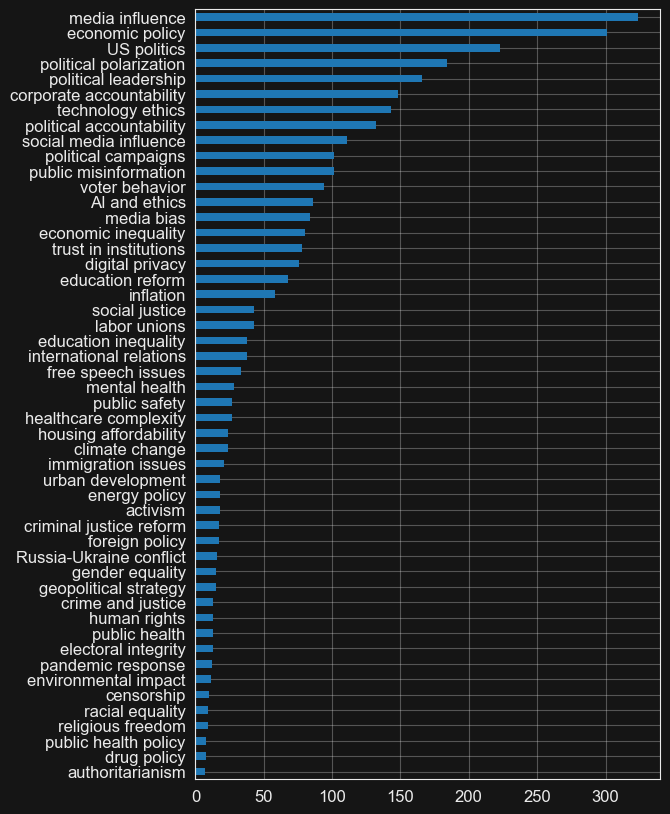

In [44]:
selected_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [45]:
residual_apply_tag_counts = pd.Series([
    tag
    for tags in selected_tags_comments['residual_tags']
    for tag in tags
]).value_counts()
residual_apply_tag_counts

tax policy                      24
fiscal policy                   23
Elon Musk                       19
monetary policy                 17
generative AI                   15
                                ..
congressional gridlock           1
socioeconomic research           1
renewable energy development     1
legislative strategy             1
preparedness planning            1
Name: count, Length: 2045, dtype: int64

<Axes: >

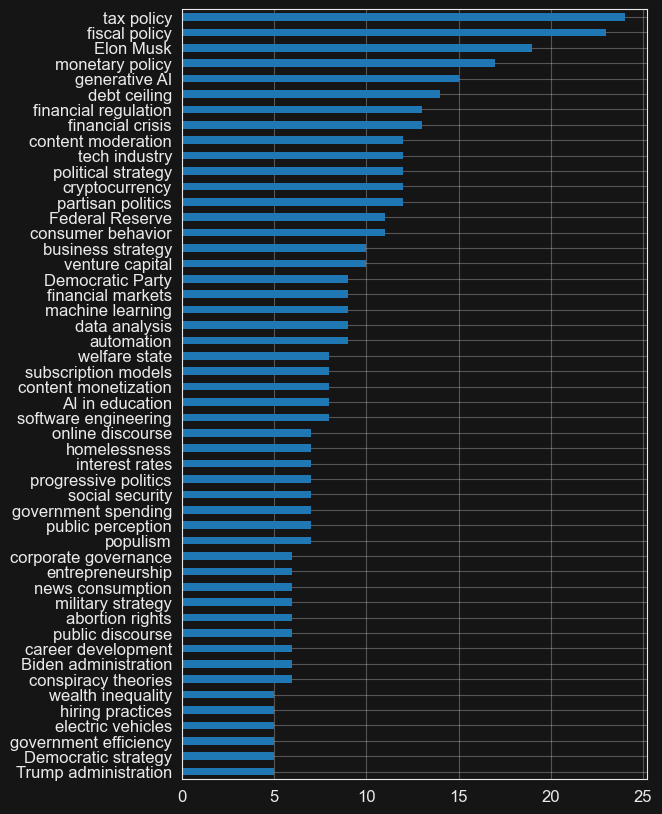

In [46]:
residual_apply_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [47]:
all_tags_count = selected_apply_tag_counts.add(residual_apply_tag_counts, fill_value=0).astype(int).sort_values(
    ascending=False)
all_tags_count

media influence           324
economic policy           304
US politics               225
political polarization    184
political leadership      167
                         ... 
employment prospects        1
employment programs         1
employment benefits         1
employment                  1
zoning reform               1
Name: count, Length: 2168, dtype: int64

<Axes: >

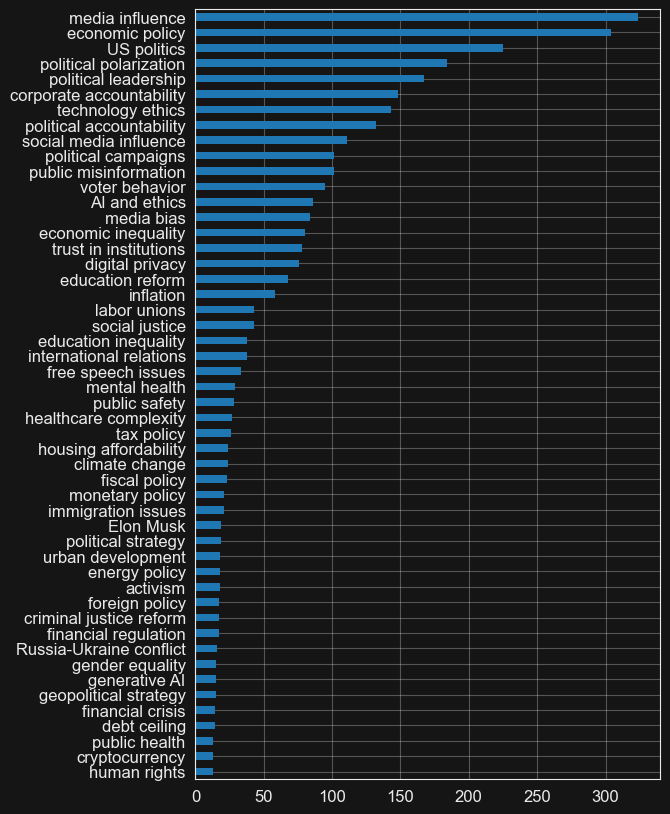

In [48]:
all_tags_count.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

In [49]:
selected_tags_comments_aug = pd.DataFrame([
    dict(id=i, tag=tag)
    for i, tags in selected_tags_comments['tags'].items()
    for tag in tags
])
selected_tags_comments_aug = pd.merge(
    selected_tags_comments_aug,
    comments,
    left_on='id',
    right_index=True,
    how='left'
)
selected_tags_comments_aug

id                      tag    post_id  \
0     10926838      political campaigns   88097777   
1     10926838           voter behavior   88097777   
2     10926838    public misinformation   88097777   
3     10926838          media influence   88097777   
4     15195301     education inequality  115956601   
...        ...                      ...        ...   
3359  96953244  international relations  157771304   
3360  96953244    geopolitical strategy  157771304   
3361  96953244  Russia-Ukraine conflict  157771304   
3362  96953244            gun ownership  157771304   
3363  96953244            public safety  157771304   

                                                  title  \
0     A lot of the best political messages are reall...   
1     A lot of the best political messages are reall...   
2     A lot of the best political messages are reall...   
3     A lot of the best political messages are reall...   
4     There's no big mystery about why colleges are ...   
...                                                 ...   
3359            Mailbag: More philosophical than usual    
3360            Mailbag: More philosophical than usual    
3361            Mailbag: More philosophical than usual    
3362            Mailbag: More philosophical than usual    
3363            Mailbag: More philosophical than usual    

                                          canonical_url       name  user_id  \
0     https://www.slowboring.com/p/a-lot-of-the-best...  Matt Hagy  3094604   
1     https://www.slowboring.com/p/a-lot-of-the-best...  Matt Hagy  3094604   
2     https://www.slowboring.com/p/a-lot-of-the-best...  Matt Hagy  3094604   
3     https://www.slowboring.com/p/a-lot-of-the-best...  Matt Hagy  3094604   
4     https://www.slowboring.com/p/sat-optional-affi...  Matt Hagy  3094604   
...                                                 ...        ...      ...   
3359  https://www.slowboring.com/p/mailbag-more-phil...  Matt Hagy  3094604   
3360  https://www.slowboring.com/p/mailbag-more-phil...  Matt Hagy  3094604   
3361  https://www.slowboring.com/p/mailbag-more-phil...  Matt Hagy  3094604   
3362  https://www.slowboring.com/p/mailbag-more-phil...  Matt Hagy  3094604   
3363  https://www.slowboring.com/p/mailbag-more-phil...  Matt Hagy  3094604   

      reaction  top_level               date  ...  parent_children  thread_id  \
0        False       True  Dec 05 2022 06:29  ...              NaN   10926838   
1        False       True  Dec 05 2022 06:29  ...              NaN   10926838   
2        False       True  Dec 05 2022 06:29  ...              NaN   10926838   
3        False       True  Dec 05 2022 06:29  ...              NaN   10926838   
4        False       True  Apr 25 2023 06:37  ...              NaN   15195301   
...        ...        ...                ...  ...              ...        ...   
3359     False      False  Feb 28 2025 15:22  ...              3.0   96819771   
3360     False      False  Feb 28 2025 15:22  ...              3.0   96819771   
3361     False      False  Feb 28 2025 15:22  ...              3.0   96819771   
3362     False      False  Feb 28 2025 15:22  ...              3.0   96819771   
3363     False      False  Feb 28 2025 15:22  ...              3.0   96819771   

     thread_children  ratio_recv  ratio_give  grade_level  word_count  \
0                 19       -94.0         NaN         12.7         108   
1                 19       -94.0         NaN         12.7         108   
2                 19       -94.0         NaN         12.7         108   
3                 19       -94.0         NaN         12.7         108   
4                324       -84.0         NaN         14.5         137   
...              ...         ...         ...          ...         ...   
3359              53         0.0        -7.0          9.5         190   
3360              53         0.0        -7.0          9.5         190   
3361              53         0.0        -7.0          9.5         190   
33

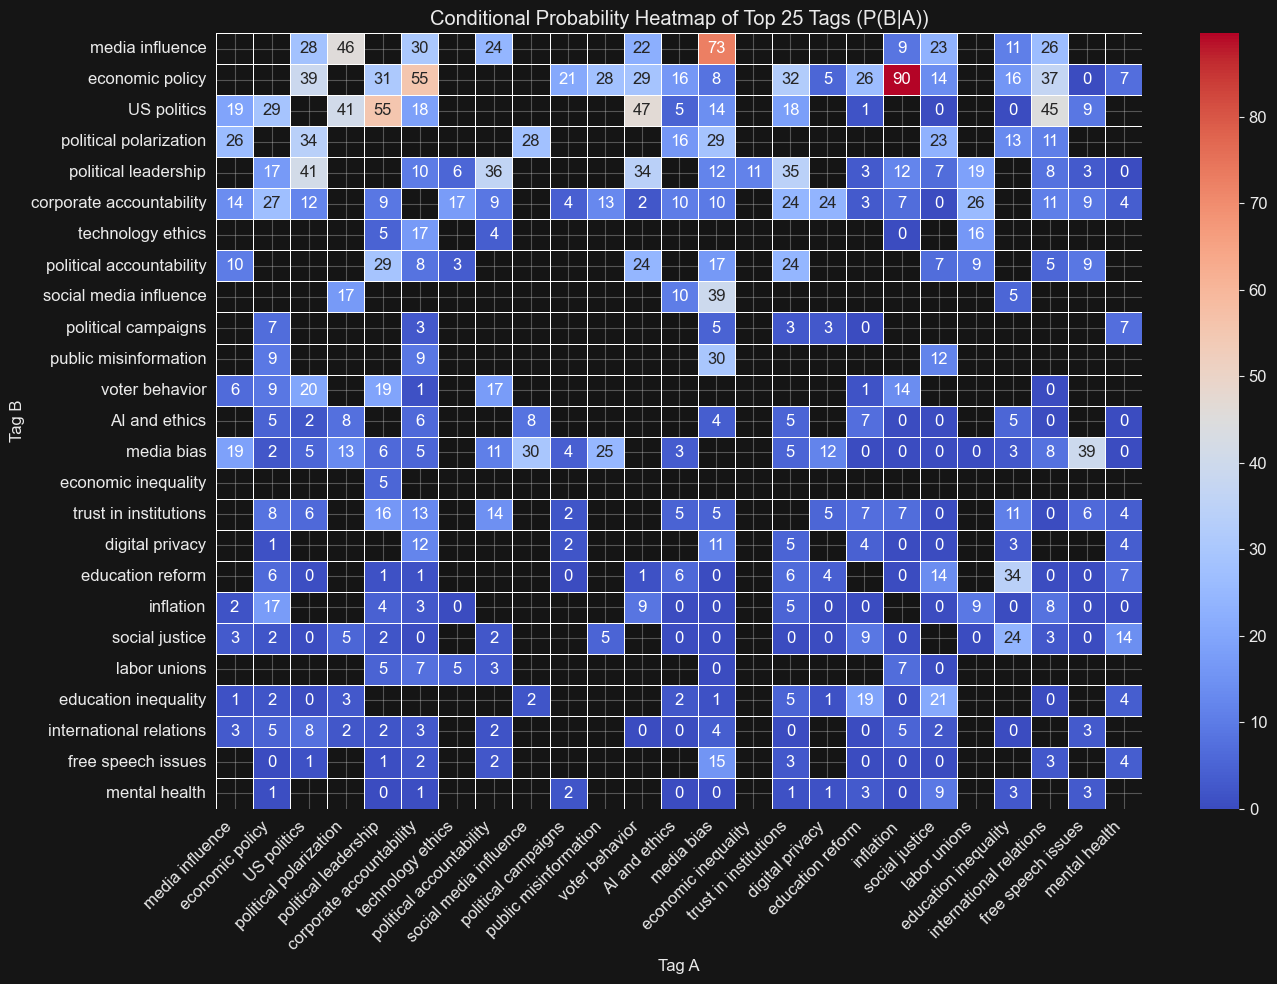

In [50]:
# Step 1: Get the top 25 most frequent tags
top_tags = selected_tags_comments_aug['tag'].value_counts().nlargest(25).index

# Step 2: Filter the dataframe for only the top tags
df_top_tags = selected_tags_comments_aug[selected_tags_comments_aug['tag'].isin(top_tags)]

# Step 3: Create a tag co-occurrence matrix
# Pivot the data to create a binary matrix for tags per id
tag_matrix = df_top_tags.pivot_table(index='id', columns='tag', aggfunc='size', fill_value=0)

# Step 4: Calculate the conditional probability matrix
# Compute the conditional probability P(B|A) where A is on the X-axis and B is on the Y-axis
tag_counts = tag_matrix.T.dot(tag_matrix)
conditional_prob_matrix = tag_counts / tag_matrix.sum(axis=0)

# Step 5: Order tags by frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_tags, top_tags]

# Step 6: Create a mask to hide the diagonal
mask = np.eye(conditional_prob_matrix.shape[0], dtype=bool) | (tag_counts < 5)

# Step 7: Create a heatmap to visualize the conditional probabilities
plt.figure(figsize=(14, 10))
sns.heatmap(conditional_prob_matrix * 100, annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask)
plt.title('Conditional Probability Heatmap of Top 25 Tags (P(B|A))')
plt.xlabel('Tag A')
plt.ylabel('Tag B')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()


In [51]:
tag_counts

tag                       AI and ethics  US politics  \
tag                                                    
AI and ethics                        86            4   
US politics                           4          223   
corporate accountability              9           27   
digital privacy                      15            0   
economic inequality                   3            9   
economic policy                      14           87   
education inequality                  2            0   
education reform                      5            1   
free speech issues                    0            3   
inflation                             0           23   
international relations               0           17   
labor unions                          5            6   
media bias                            3           12   
media influence                      29           63   
mental health                         0            0   
political accountability              2           66   
political campaigns                   3           56   
political leadership                  3           92   
political polarization               14           75   
public misinformation                 5           20   
social justice                        0            0   
social media influence                9            8   
technology ethics                    57            8   
trust in institutions                 4           14   
voter behavior                        1           44   

tag                       corporate accountability  digital privacy  \
tag                                                                   
AI and ethics                                    9               15   
US politics                                     27                0   
corporate accountability                       148               18   
digital privacy                                 18               76   
economic inequality                             15                1   
economic policy                                 82                4   
education inequality                             0                1   
education reform                                 2                3   
free speech issues                               3                6   
inflation                                        4                0   
international relations                          4                0   
labor unions                                    11                0   
media bias                                       8                9   
media influence                                 45               40   
mental health                                    1                1   
political accountability                        12                0   
political campaigns                              4                2   
political leadership                            15                1   
political polarization                           3                1   
public misinformation                           13                5   
social justice                                   0                0   
social media influence                           7               17   
technology ethics                               25               38   
trust in institutions                           19                4   
voter behavior                                   2                0   

tag                       economic inequality  economic policy  \
tag                                                              
AI and ethics                               3               14   
US politics                                 9               87   
corporate accountability                   15               82   
digital privacy                             1                4   
economic inequality                        80               24   
economic policy                            24              301   
education inequality                     

In [52]:
tag_matrix.sum(axis=0)

tag
AI and ethics                86
US politics                 223
corporate accountability    148
digital privacy              76
economic inequality          80
economic policy             301
education inequality         38
education reform             68
free speech issues           33
inflation                    58
international relations      38
labor unions                 43
media bias                   84
media influence             324
mental health                28
political accountability    132
political campaigns         101
political leadership        166
political polarization      184
public misinformation       101
social justice               43
social media influence      111
technology ethics           143
trust in institutions        78
voter behavior               94
dtype: int64

In [49]:
with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(selected_tags_comments['tags'].sort_index().items()), f, indent=2)

In [50]:
tags_to_define = sorted(all_tags_count.head(200).index)
tags_to_define

['AI advancements',
 'AI and ethics',
 'AI applications',
 'AI in education',
 'AI regulation',
 'Biden administration',
 'Democratic Party',
 'Democratic strategy',
 'Elon Musk',
 'Federal Reserve',
 'Republican Party',
 'Russia-Ukraine conflict',
 'Trump',
 'US economy',
 'US politics',
 'US-China relations',
 'abortion debate',
 'abortion rights',
 'activism',
 'advertising revenue',
 'algorithmic curation',
 'antisemitism',
 'antitrust issues',
 'authoritarianism',
 'automation',
 'bank regulation',
 'banking crisis',
 'banking industry',
 'banking regulation',
 'billionaire influence',
 'bipartisanship',
 'bond market',
 'bureaucracy',
 'business innovation',
 'business strategy',
 'capitalism',
 'career development',
 'censorship',
 'central banking',
 'charter schools',
 'class dynamics',
 'climate change',
 'coalition dynamics',
 'comment analysis',
 'community engagement',
 'conspiracy theories',
 'constitutional law',
 'consumer behavior',
 'content moderation',
 'content mon

In [58]:
tags_define_response = PROMPT_CACHE.get_or_create(
    prompt_rel_path=Path('tag_define/v0.txt'),
    cache_key=f'tags_to_define',
    template_values=dict(tags=json.dumps(tags_to_define)),
    run_prompt_kwds=dict(response_format={"type": "json_object"}),
    cache_suffix='json'
)
tag_definitions = pd.DataFrame(json.loads(tags_define_response.strip())['tag_definitions'])
assert set(tag_definitions.columns) == {'tag', 'definition'}, f'columns: {tag_definitions.columns}'
tag_definitions

{"tag_definitions": [
    { "tag": "AI advancements", "definition": "Developments and breakthroughs in artificial intelligence technology." },
    { "tag": "AI and ethics", "definition": "The study of moral implications and ethical considerations of artificial intelligence use and development." },
    { "tag": "AI applications", "definition": "Practical uses and implementations of artificial intelligence across various industries." },
    { "tag": "AI communication", "definition": "The interaction between artificial intelligence systems and humans or other machines." },
    { "tag": "AI in education", "definition": "The integration and impact of artificial intelligence in educational settings and learning processes." },
    { "tag": "AI regulation", "definition": "Laws and guidelines governing the development and deployment of artificial intelligence technologies." },
    { "tag": "Biden administration", "definition": "The executive actions and policies under the presidency of Joe Bide

tag                                         definition
0          AI advancements  Developments and breakthroughs in artificial i...
1            AI and ethics  The study of moral implications and ethical co...
2          AI applications  Practical uses and implementations of artifici...
3         AI communication  The interaction between artificial intelligenc...
4          AI in education  The integration and impact of artificial intel...
..                     ...                                                ...
195         voter behavior  The patterns of behavior exhibited by voters a...
196      wealth inequality  The uneven distribution of assets among a popu...
197  wealth redistribution  The reallocation of wealth and income across d...
198           web scraping  The automated extraction of data from websites...
199          welfare state  A government system that provides social and e...

[200 rows x 2 columns]

In [59]:
(pd.concat([
    all_tags_count.rename('count'),
    tag_definitions.set_index('tag')['definition'],
], axis=1)
 .sort_values('count', ascending=False)
 .to_clipboard(index=True))

In [53]:
selected_defined_tags = pd.read_csv(DATA_DIR / 'Hagy Comment Tag Definitions - 2025-01-01 - Sheet1.csv')
selected_defined_tags = selected_defined_tags[selected_defined_tags['select']].drop(['select'], axis=1)
selected_defined_tags

tag  count  \
0           economic policy    284   
1           media influence    255   
2               US politics    175   
3    political polarization    156   
8    social media influence     89   
..                      ...    ...   
173     advertising revenue      3   
175     historical analysis      3   
179     right-wing politics      3   
181              gun rights      3   
189           progressivism      3   

                                            definition  
0    A course of action taken by a government to in...  
1    The impact that media has on shaping public op...  
2    The political activities, events, and policies...  
3    The process by which political attitudes diver...  
8    The impact that social media platforms and per...  
..                                                 ...  
173  Income generated from the promotion of product...  
175  The examination of past events to understand t...  
179  Political ideologies and movements that emphas...  
181  The belief in and advocacy for the legal right...  
189  A political and social philosophy advocating f...  

[77 rows x 3 columns]

In [54]:
# selected_defined_tags.to_clipboard(index=False)

In [55]:
tag_definitions = selected_defined_tags[['tag', 'definition']].sort_values('tag').reset_index(drop=True)
tag_definitions

tag                                         definition
0      Biden administration  The executive branch of the U.S. government un...
1          Democratic Party  One of the two major political parties in the ...
2           Federal Reserve  The central banking system of the United State...
3   Russia-Ukraine conflict  The ongoing geopolitical and military tensions...
4               US politics  The political activities, events, and policies...
..                      ...                                                ...
72               tax policy  Governmental guidelines that dictate how taxes...
73                 taxation  The system through which a government raises r...
74            tech industry  The sector focused on research, development, a...
75    trust in institutions  The public's confidence in the reliability and...
76            welfare state  A governmental system that provides social and...

[77 rows x 2 columns]

In [56]:
print(tag_definitions.to_json(orient='records', index=False))

[{"tag":"Biden administration","definition":"The executive branch of the U.S. government under President Joe Biden."},{"tag":"Democratic Party","definition":"One of the two major political parties in the United States, generally associated with liberal policies."},{"tag":"Federal Reserve","definition":"The central banking system of the United States responsible for monetary policy."},{"tag":"Russia-Ukraine conflict","definition":"The ongoing geopolitical and military tensions between Russia and Ukraine."},{"tag":"US politics","definition":"The political activities, events, and policies related to the governance of the United States."},{"tag":"abortion rights","definition":"The belief in or advocacy for the legal right to access abortion services."},{"tag":"activism","definition":"Efforts and actions aimed at promoting, impeding, or directing social, political, or environmental change."},{"tag":"advertising revenue","definition":"Income generated from the promotion of products or servic

In [57]:
defined_tags_comments = []
for i, (_, comment) in enumerate(best_comments.head(1000).iterrows()):
    print(f'comment {i}')
    tag_comment_response = PROMPT_CACHE.get_or_create(
        prompt_rel_path=Path('tag_comment_defined/v0.txt'),
        cache_key=f'comment_{comment.name}',
        template_values=dict(tag_definitions=tag_definitions.to_json(orient='records', index=False),
                             comment=comment['body']),
        run_prompt_kwds=dict(response_format={"type": "json_object"}),
        cache_suffix='json'
    )
    tag_comment = json.loads(tag_comment_response)
    assert set(tag_comment.keys()) == {'tags'}, f'keys: {tag_comment.keys()}'
    tag_comment['id'] = comment.name
    defined_tags_comments.append(tag_comment)
defined_tags_comments = pd.DataFrame(defined_tags_comments).set_index('id')
defined_tags_comments

comment 0
comment 1
comment 2
comment 3
comment 4
comment 5
comment 6
comment 7
comment 8
comment 9
comment 10
comment 11
comment 12
comment 13
comment 14
comment 15
comment 16
comment 17
comment 18
comment 19
comment 20
comment 21
comment 22
comment 23
comment 24
comment 25
comment 26
comment 27
comment 28
comment 29
comment 30
comment 31
comment 32
comment 33
comment 34
comment 35
comment 36
comment 37
comment 38
comment 39
comment 40
comment 41
comment 42
comment 43
comment 44
comment 45
comment 46
comment 47
comment 48
comment 49
comment 50
comment 51
comment 52
comment 53
comment 54
comment 55
comment 56
comment 57
comment 58
comment 59
comment 60
comment 61
comment 62
comment 63
comment 64
comment 65
comment 66
comment 67
comment 68
comment 69
comment 70
comment 71
comment 72
comment 73
comment 74
comment 75
comment 76
comment 77
comment 78
comment 79
comment 80
comment 81
comment 82
comment 83
comment 84
comment 85
comment 86
comment 87
comment 88
comment 89
comment 90
comment 9

tags
id                                                         
10926838    [Democratic Party, populism, identity politics]
15195301  [education inequality, crime and justice, high...
10138366  [tech industry, labor market, business strateg...
13140414  [media influence, public misinformation, polit...
12967487                          [taxation, law and order]
...                                                     ...
14480060                                                 []
98926692                                                 []
97365109                                                 []
3901854                    [education reform, labor market]
96953244  [Russia-Ukraine conflict, gun rights, US polit...

[1000 rows x 1 columns]

In [58]:
defined_tag_counts = pd.Series([
    tag
    for tags in defined_tags_comments['tags']
    for tag in tags
]).value_counts()
defined_tag_counts

US politics                  250
media influence              157
economic policy              154
tech industry                147
partisan politics            139
                            ... 
moral philosophy               1
government accountability      1
gender issues                  1
democracy                      1
employment law                 1
Name: count, Length: 185, dtype: int64

<Axes: >

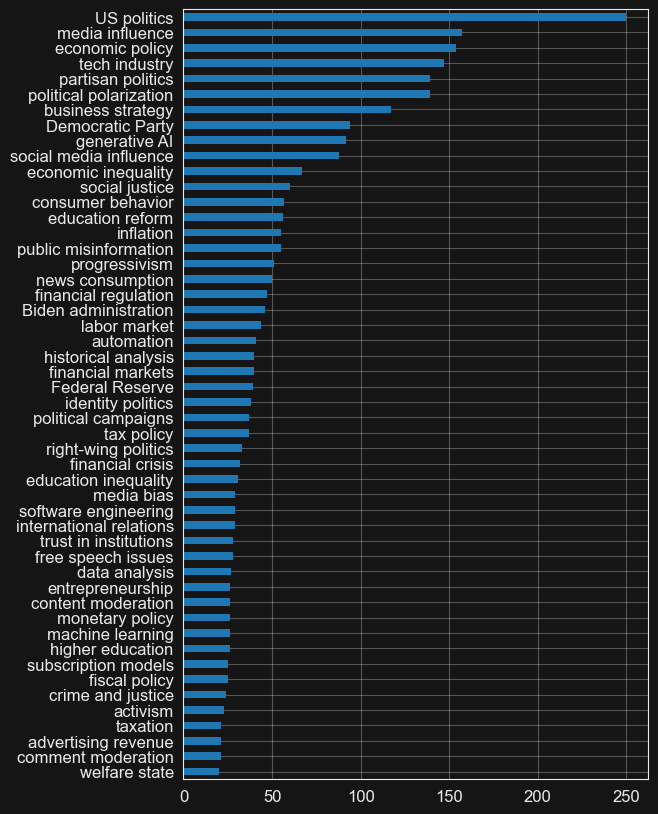

In [59]:
defined_tag_counts.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

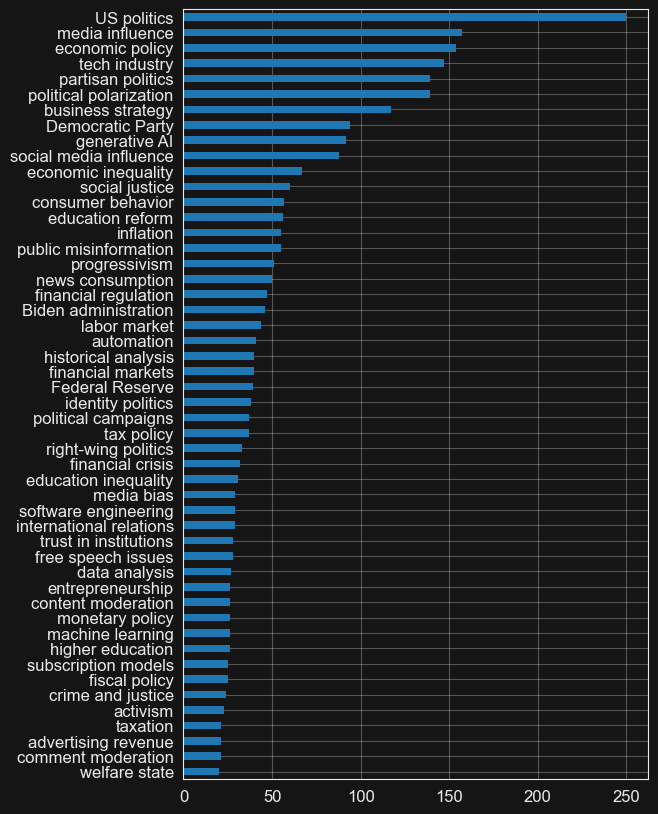

In [60]:
defined_tag_counts_in_given = defined_tag_counts[defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

<Axes: >

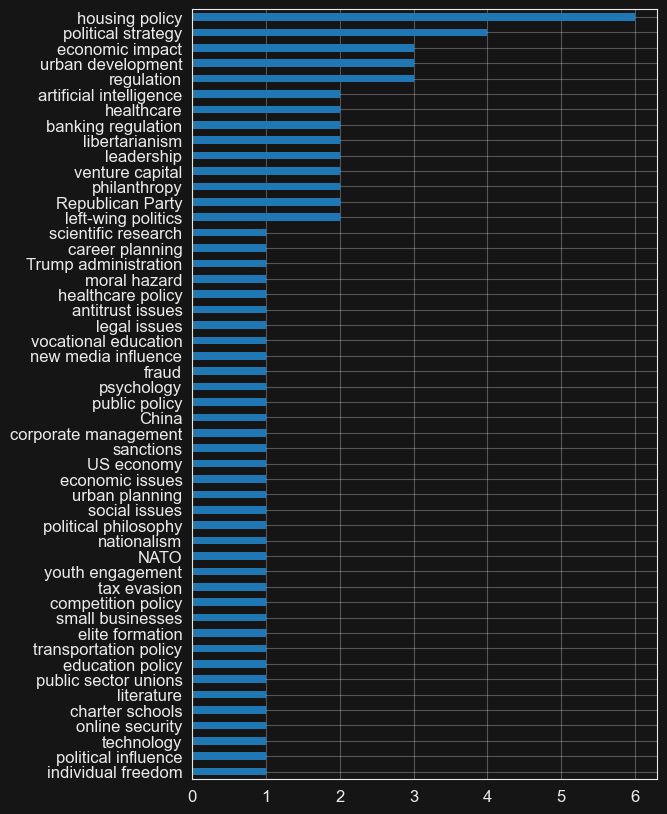

In [61]:
defined_tag_counts_not_in_given = defined_tag_counts[~defined_tag_counts.index.isin(tag_definitions['tag'])]
defined_tag_counts_not_in_given.head(50).iloc[::-1].plot.barh(figsize=(6, 10))

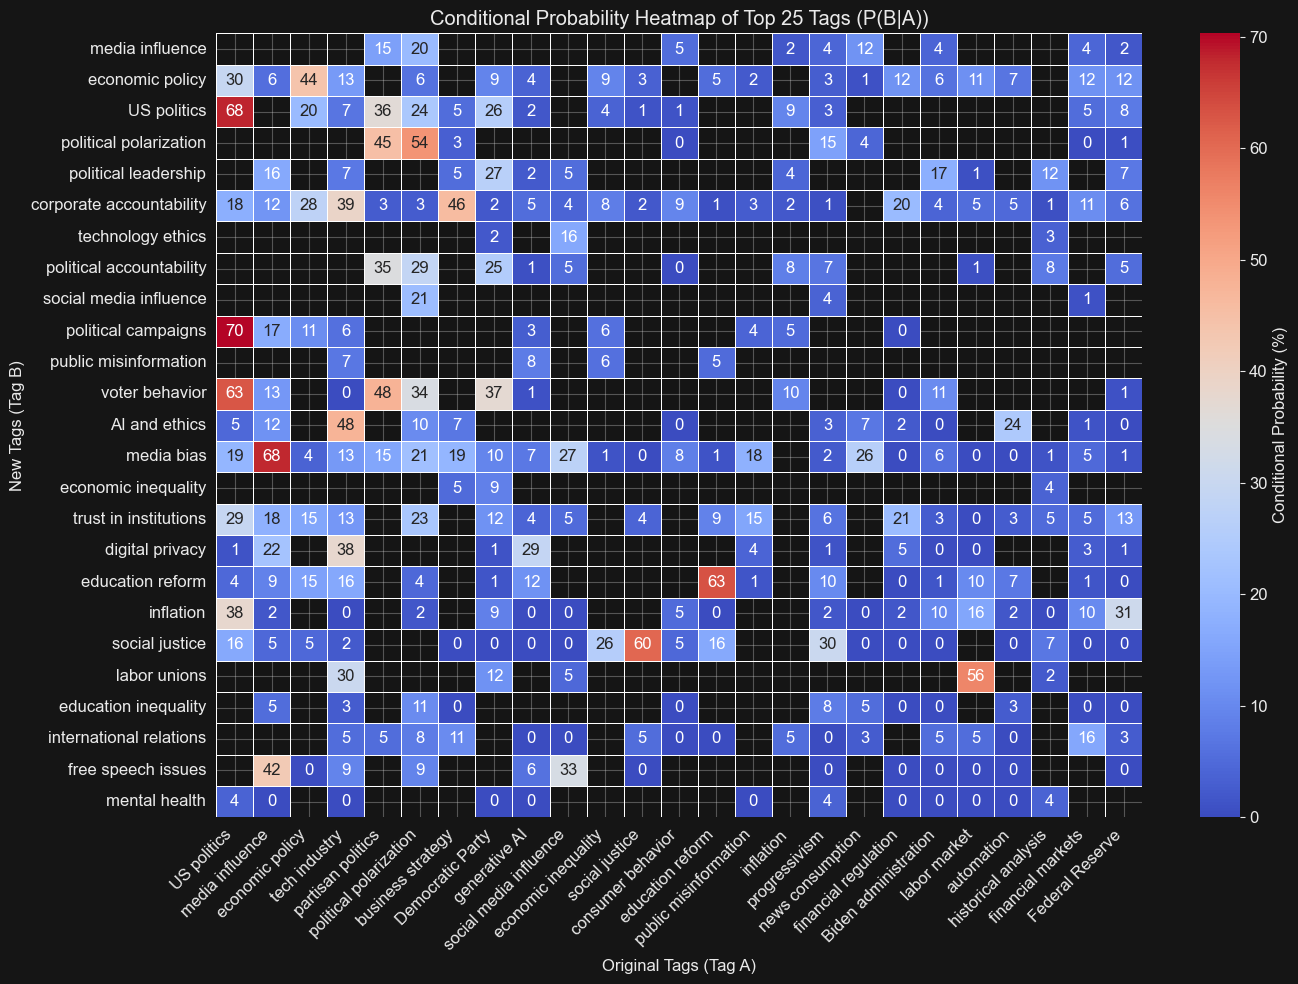

In [62]:
# Step 1: Flatten the tags into DataFrames
selected_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in selected_tags_comments['tags'].items() for tag in tags],
    columns=['id', 'tag']
)
defined_tags_set = set(tag_definitions['tag'])
defined_flat = pd.DataFrame(
    [(id_, tag) for id_, tags in defined_tags_comments['tags'].items()
     for tag in tags
     if tag in defined_tags_set],
    columns=['id', 'tag']
)

# Step 2: Get the top 25 tags for each group
top_selected_tags = selected_flat['tag'].value_counts().nlargest(25).index
top_defined_tags = defined_flat['tag'].value_counts().nlargest(25).index

# Step 3: Filter the DataFrames for only the top tags
selected_top = selected_flat[selected_flat['tag'].isin(top_selected_tags)]
defined_top = defined_flat[defined_flat['tag'].isin(top_defined_tags)]

# Step 4: Merge the two DataFrames on the "id" column
merged_tags = selected_top.merge(defined_top, on='id', suffixes=('_original', '_defined'), how='inner')

# Step 5: Create a co-occurrence matrix
cooccurrence_matrix = pd.crosstab(
    merged_tags['tag_original'], merged_tags['tag_defined']
)

# Step 6: Calculate the correct normalization denominator
# Group by original tags to count unique IDs per tag
denominator = selected_top.groupby('tag')['id'].nunique()

# Normalize the co-occurrence matrix using the correct denominator
conditional_prob_matrix = cooccurrence_matrix.div(denominator, axis=0)

# Step 7: Reorder rows and columns based on top tags frequency
conditional_prob_matrix = conditional_prob_matrix.loc[top_selected_tags, top_defined_tags]

# Step 8: Create a mask for cells with low counts (<5 occurrences)
mask = cooccurrence_matrix < 5

# Step 9: Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    conditional_prob_matrix * 100,  # Convert probabilities to percentages
    annot=True, fmt='.0f', cmap='coolwarm', linewidths=0.5, mask=mask, cbar_kws={'label': 'Conditional Probability (%)'}
)
plt.title('Conditional Probability Heatmap of Top 25 Tags (P(B|A))')
plt.xlabel('Original Tags (Tag A)')
plt.ylabel('New Tags (Tag B)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Display the heatmap
plt.show()

<Axes: ylabel='tag'>

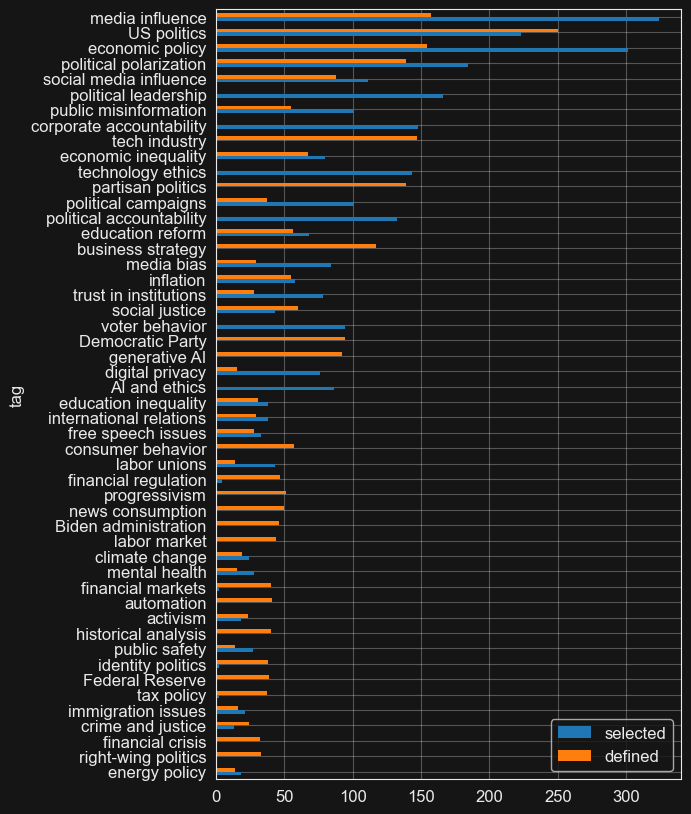

In [63]:
(pd.concat([
    selected_flat['tag'].value_counts(),
    defined_flat['tag'].value_counts(),
], axis=1, keys=['selected', 'defined'])
 .fillna(0).astype(int)
 .assign(total=lambda df: df['selected'] + df['defined'])
 .sort_values('total', ascending=False)
 .head(50)
 .drop(['total'], axis=1)
 .iloc[::-1]
 .plot.barh(figsize=(6, 10))
 )

In [64]:
selected_flat['tag'].value_counts()

tag
media influence           324
economic policy           301
US politics               223
political polarization    184
political leadership      166
                         ... 
supply chain                1
public employment           1
pension reform              1
cultural critique           1
gun ownership               1
Name: count, Length: 185, dtype: int64

In [65]:
def select_sort_tags(tags: list[str]) -> list[str]:
    return sorted(tag for tag in tags if tag in defined_tags_set)


with COMMENT_TAGS_PATH.open('w') as f:
    json.dump(dict(defined_tags_comments['tags'].map(select_sort_tags).sort_index().items()), f, indent=2)

In [66]:
defined_tag_counts.head(5)

US politics          250
media influence      157
economic policy      154
tech industry        147
partisan politics    139
Name: count, dtype: int64

In [67]:
tag = defined_tag_counts.index[0]
tag_definition, = tag_definitions[tag_definitions["tag"] == tag]["definition"]
print(f'{tag=}: {tag_definition=}')
tag_comments = best_comments[
    best_comments.index.isin(defined_tags_comments[defined_tags_comments['tags'].map(lambda tags: tag in tags)].index)]
print(f'{len(tag_comments)=}')
top_tag_comments = tag_comments.sort_values('likes', ascending=False).head(100)
print(f'{len(top_tag_comments)=}')
tag_comments_formatted = '\n\n'.join(
    f'Comment {i}:\n{body}'
    for i, body in enumerate(top_tag_comments['body'], 1)
)
# print(tag_comments_formatted)
print(f'{openai_util.count_tokens(tag_comments_formatted)=}')

tag='US politics': tag_definition='The political activities, events, and policies related to the governance of the United States.'
len(tag_comments)=250
len(top_tag_comments)=100
openai_util.count_tokens(tag_comments_formatted)=23485


In [68]:
summarize_tagged_comments_response = PROMPT_CACHE.get_or_create(
    prompt_rel_path=Path('summarize_tagged_comments/v0.txt'),
    cache_key=f'hagy_{tag}',
    template_values=dict(tag=tag, definition=tag_definition, comments=tag_comments_formatted),
    cache_suffix='md'
)

- **Polarization and Misunderstanding**: Discussions highlight a disconnect between political groups, attributing Trump's rise not just to misinformation but also to differing values and beliefs, complicating efforts at compromise within U.S. politics.
- **Gun Control Complexity**: Comments reflect a paradox in American views on gun control, with some advocating for stricter measures while recognizing enforcement challenges, leading to contradictions in activist approaches.
- **Political Extremism**: There is concern over political extremes shaping narratives, where moderates are drowned out, causing negative polarization and fueling an uncompromising political climate.
- **Economic Discussions**: Debates emphasize the challenges in balancing economic policies, such as tax reforms and government interventions, against political pressures and public opinions, showing a gap between technocratic solutions and electoral politics.
- **Democratic Processes and Leadership**: Comments express 

In [69]:
display(Markdown(summarize_tagged_comments_response))

- **Polarization and Misunderstanding**: Discussions highlight a disconnect between political groups, attributing Trump's rise not just to misinformation but also to differing values and beliefs, complicating efforts at compromise within U.S. politics.
- **Gun Control Complexity**: Comments reflect a paradox in American views on gun control, with some advocating for stricter measures while recognizing enforcement challenges, leading to contradictions in activist approaches.
- **Political Extremism**: There is concern over political extremes shaping narratives, where moderates are drowned out, causing negative polarization and fueling an uncompromising political climate.
- **Economic Discussions**: Debates emphasize the challenges in balancing economic policies, such as tax reforms and government interventions, against political pressures and public opinions, showing a gap between technocratic solutions and electoral politics.
- **Democratic Processes and Leadership**: Comments express frustration over the Democratic Party's challenges in coalition-building and leadership choices, revealing a need for strategic adjustments to appeal to a broader electorate.
- **Media and Political Narratives**: Criticism is directed at media for portraying simplified and biased narratives, particularly around significant political figures, leading to skepticism and a need for nuanced discourse.
- **Judicial and Legislative Dynamics**: Concerns about the U.S. judicial system's role in politics are raised, including debates on the Supreme Court's influence and the legislative gridlock affecting governance and policy development.
- **Socioeconomic Issues**: Discussions highlight complexities in addressing societal challenges, such as housing markets and healthcare, underscoring the difficulty in formulating policies that balance economic realities with social justice goals.

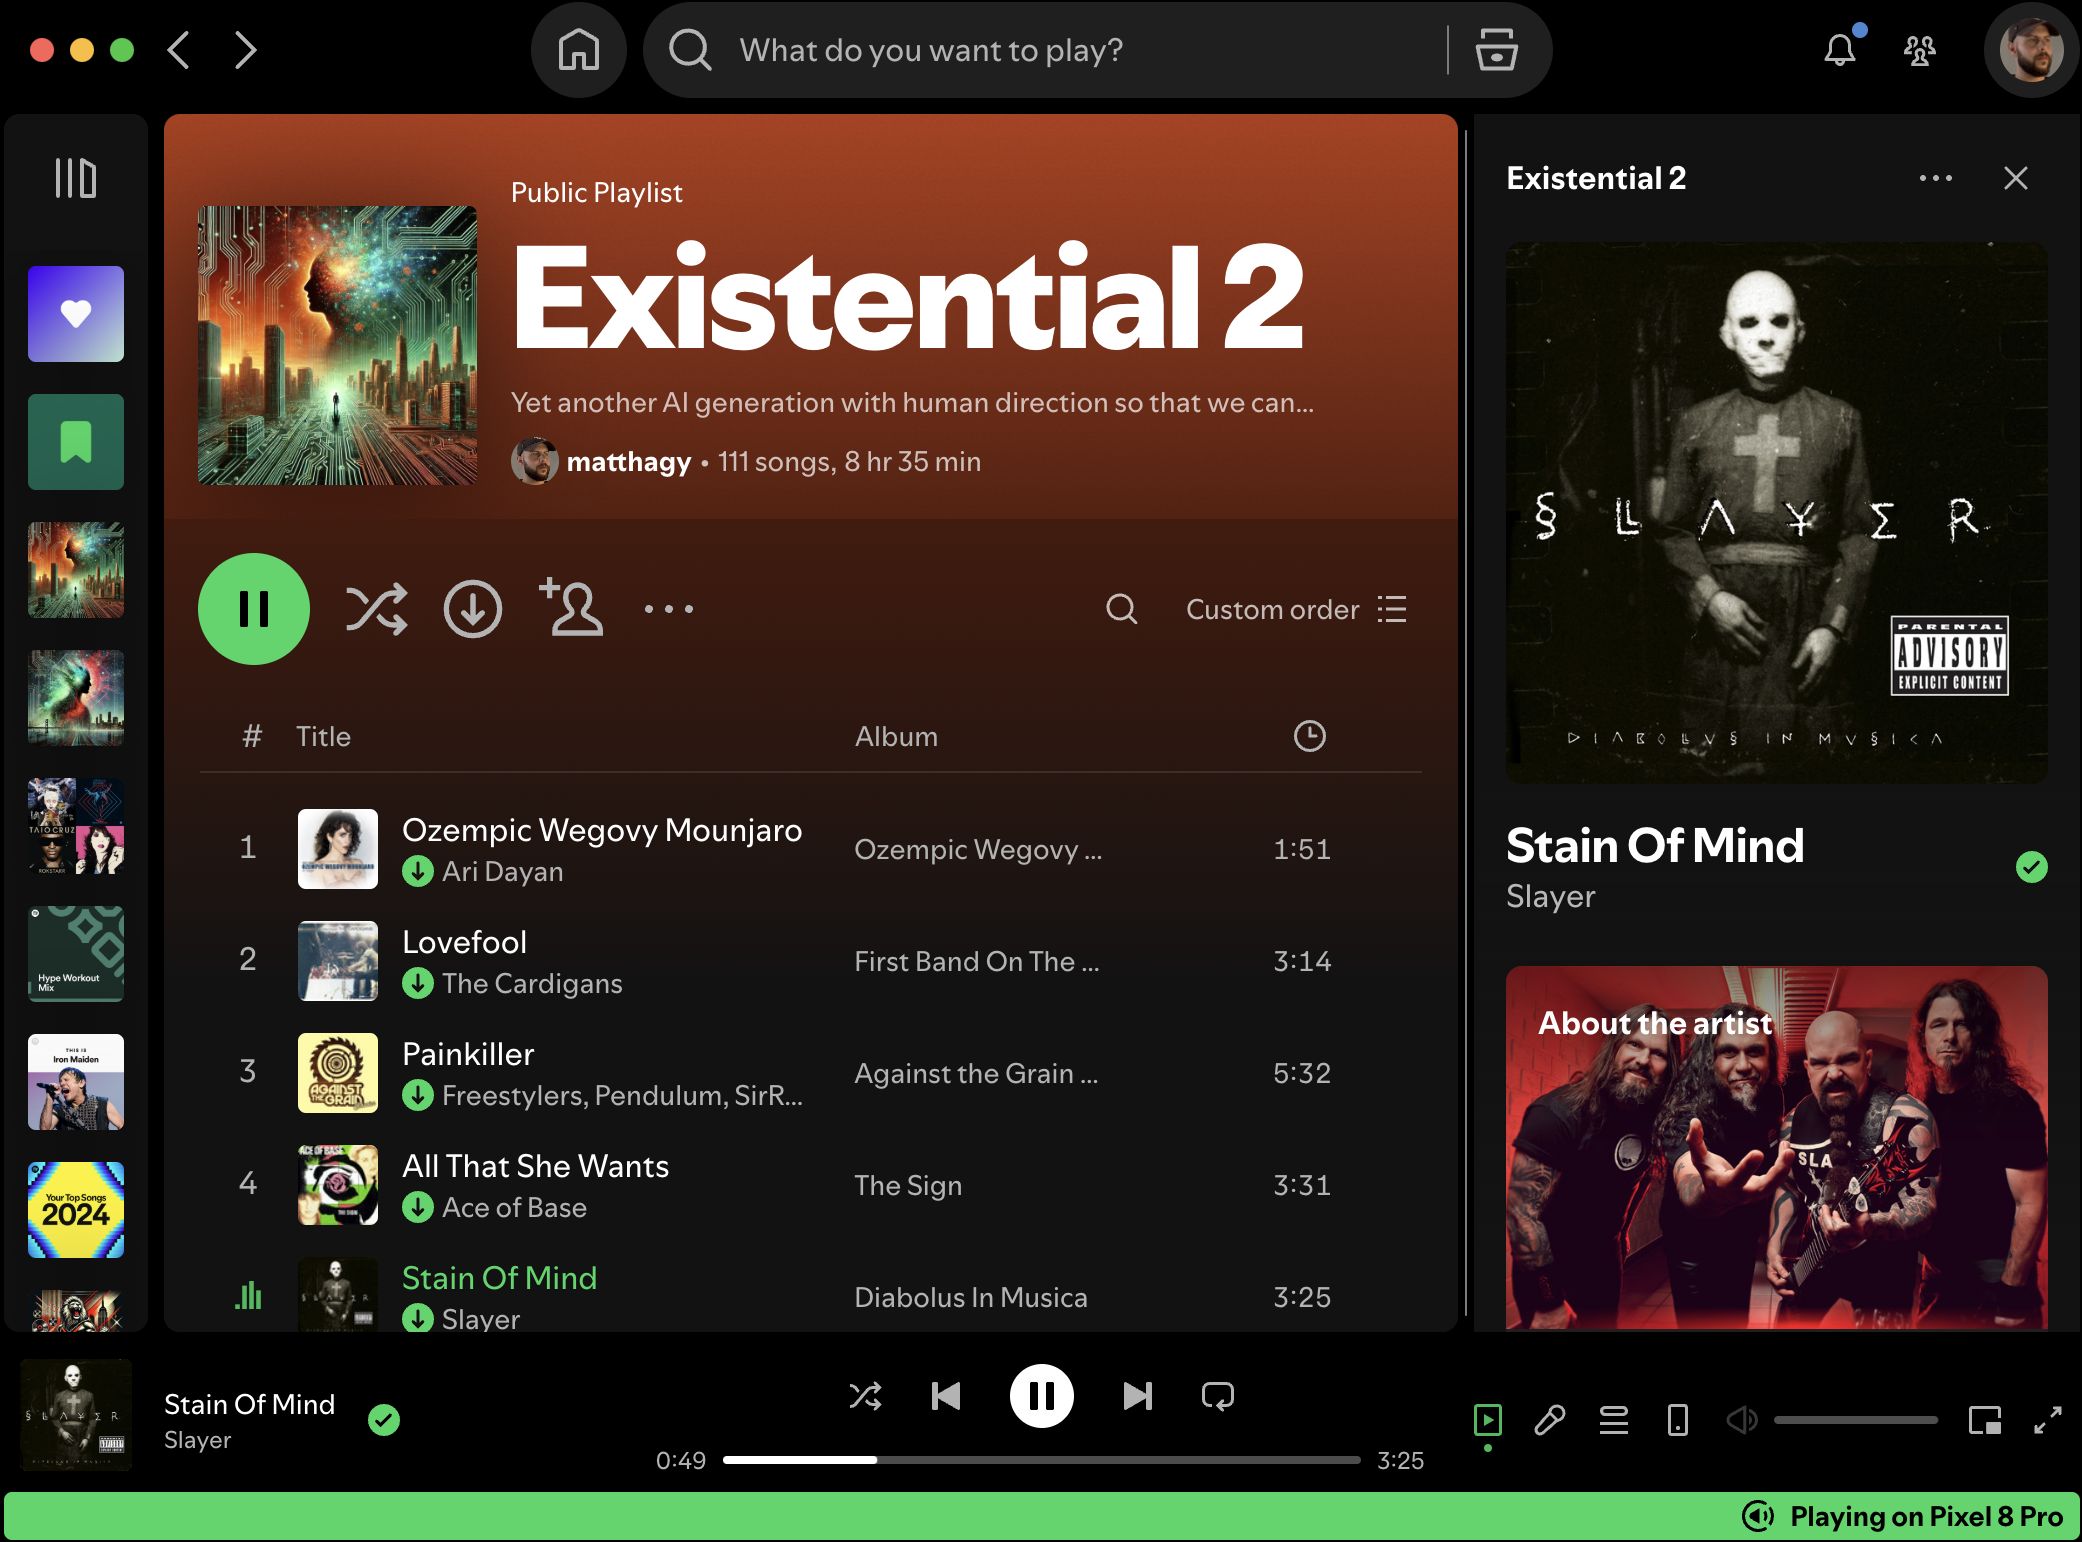

In [71]:
from IPython.display import Image
from pathlib import Path
display(Image(Path('~/Downloads/wip-music.png').expanduser()))